In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/sales_datewise.csv', encoding= 'unicode_escape')
df

,ORDER_DATE,AMOUNT_SPENT
0,7/1/2018,7516.37
1,7/2/2018,8947.50
2,7/3/2018,10268.88
3,7/4/2018,10143.30
4,7/5/2018,7088.92
...,...,...
544,12/27/2019,12797.01
545,12/28/2019,7873.96
546,12/29/2019,8100.44
547,12/30/2019,9992.00


 # Seasonal Naive Bayes Model 

In [ ]:
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'], format='%m/%d/%Y') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['ORDER_DATE'].dt.year
df['month'] = df['ORDER_DATE'].dt.month
df['day'] = df['ORDER_DATE'].dt.day
df['weekday'] = df['ORDER_DATE'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('ORDER_DATE')
train_df = temp_df.loc[:'2019-09-30'].reset_index(drop=False)                         
test_df = temp_df.loc['2019-10-01':].reset_index(drop=False)

train_df.head()

,ORDER_DATE,AMOUNT_SPENT,year,month,day,weekday
0,2018-07-01,7516.37,2018,7,1,6
1,2018-07-02,8947.50,2018,7,2,7
2,2018-07-03,10268.88,2018,7,3,1
3,2018-07-04,10143.30,2018,7,4,2
4,2018-07-05,7088.92,2018,7,5,3


In [ ]:
test_df.head()

,ORDER_DATE,AMOUNT_SPENT,year,month,day,weekday
0,2019-10-01,18898.27,2019,10,1,1
1,2019-10-02,13784.86,2019,10,2,2
2,2019-10-03,10376.69,2019,10,3,3
3,2019-10-04,7201.74,2019,10,4,4
4,2019-10-05,7033.30,2019,10,5,5


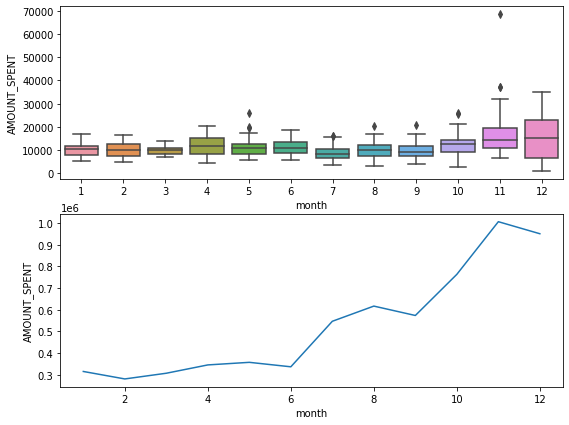

In [ ]:
monthly_agg = df.groupby('month')['AMOUNT_SPENT'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='AMOUNT_SPENT', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='AMOUNT_SPENT', data=monthly_agg, ax=axs[1])

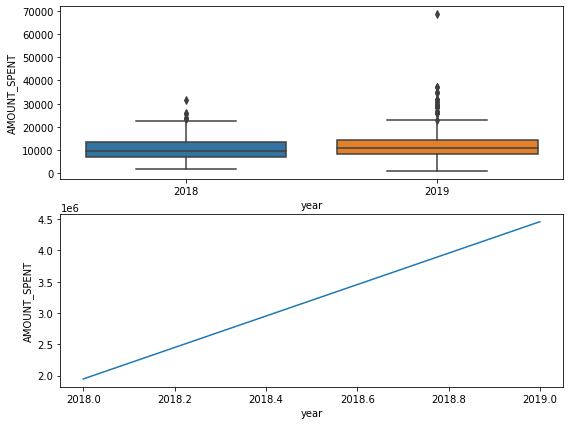

In [ ]:
yearly_agg = df.groupby('year')['AMOUNT_SPENT'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='AMOUNT_SPENT', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='AMOUNT_SPENT', data=yearly_agg, ax=axs[1])

In [ ]:
# subtract 1 year from test data
dates = (test_df['ORDER_DATE'] - np.timedelta64(3, 'M') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') 
seasonal_naive_sales = train_df[train_df['ORDER_DATE'].astype('datetime64[D]').isin(dates)]['AMOUNT_SPENT'] 

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('AMOUNT_SPENT', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()

ValueError: ignored

KeyError: ignored

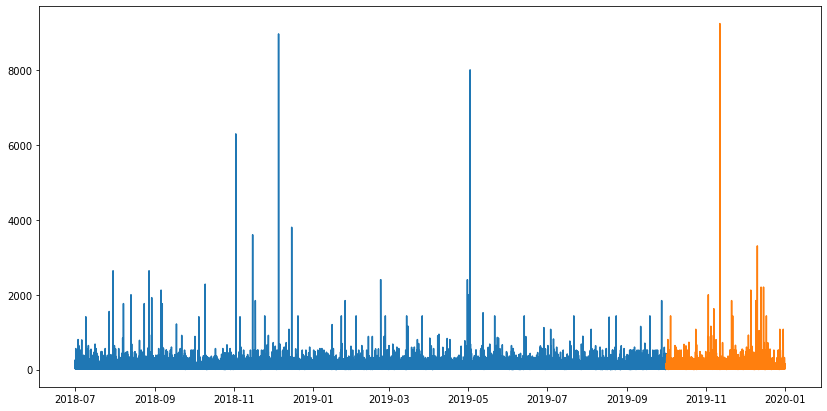

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(train_df['ORDER_DATE'], train_df['AMOUNT_SPENT'], label='Train')
plt.plot(test_df['ORDER_DATE'], test_df['AMOUNT_SPENT'], label='Test')
plt.plot(sn_pred_df['ORDER_DATE'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('ORDER_DATE')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

# ARIMA Model

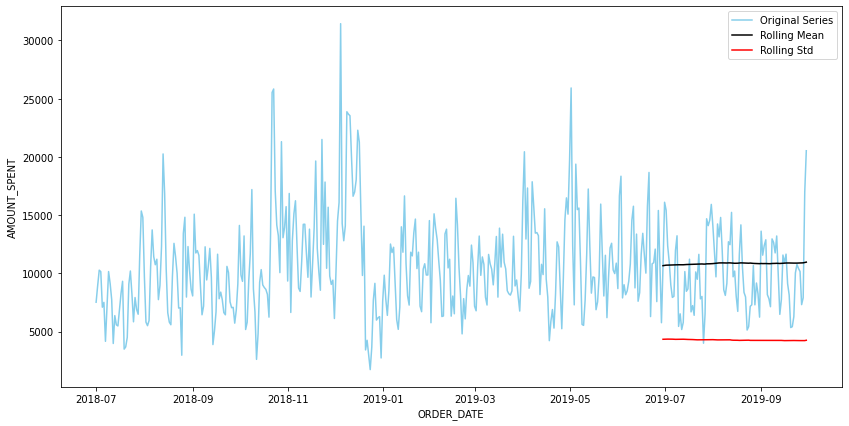

Test statistic = -6.091
P-value = 0.000
Critical values :
	1%: -3.4450973903602367 - The data is  stationary with 99% confidence
	5%: -2.868042229965336 - The data is  stationary with 95% confidence
	10%: -2.570233448893 - The data is  stationary with 90% confidence


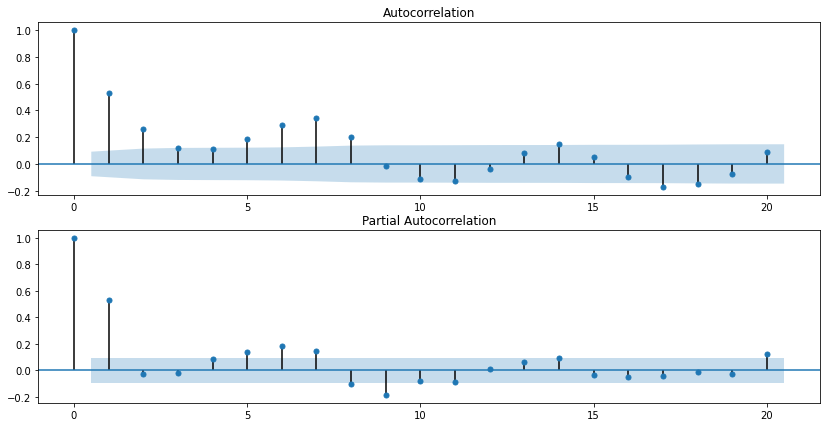

In [ ]:
arima_df = train_df[['ORDER_DATE', 'AMOUNT_SPENT']].set_index('ORDER_DATE')
arima_test_df = test_df[['ORDER_DATE', 'AMOUNT_SPENT']].set_index('ORDER_DATE')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('ORDER_DATE')
    plt.ylabel('AMOUNT_SPENT')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df.AMOUNT_SPENT)


In [ ]:
arima_df

,AMOUNT_SPENT
ORDER_DATE,
2018-07-01,7516.37
2018-07-02,8947.50
2018-07-03,10268.88
2018-07-04,10143.30
2018-07-05,7088.92
...,...
2019-09-26,10155.56
2019-09-27,7309.80
2019-09-28,7901.68


In [ ]:
arima_model61 = ARIMA(arima_df.AMOUNT_SPENT, (3,0,1)).fit(disp=False) #p=1,3 d=0, q=0 or 1 or 
print(arima_model61.summary())

                              ARMA Model Results                              
Dep. Variable:           AMOUNT_SPENT   No. Observations:                  457
Model:                     ARMA(3, 1)   Log Likelihood               -4373.387
Method:                       css-mle   S.D. of innovations           3464.762
Date:                Sun, 27 Sep 2020   AIC                           8758.773
Time:                        06:35:38   BIC                           8783.521
Sample:                    07-01-2018   HQIC                          8768.521
                         - 09-30-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.056e+04    461.331     22.889      0.000    9655.095    1.15e+04
ar.L1.AMOUNT_SPENT     1.3059      0.106     12.282      0.000       1.098       1.514
ar.L2.AMOUNT_SPENT  

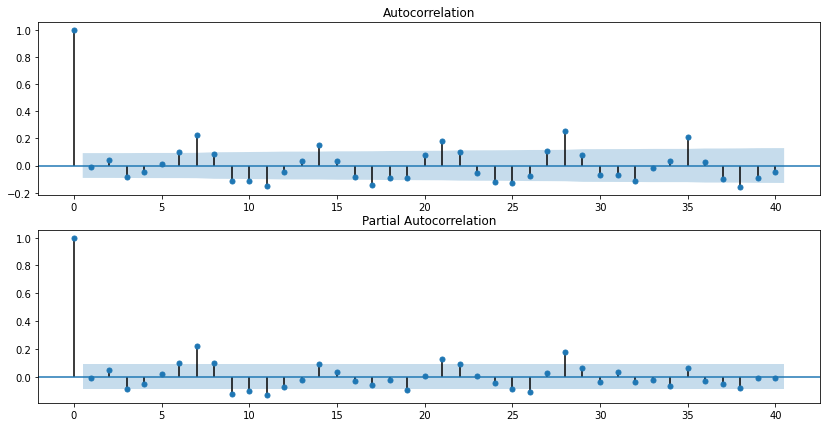

In [ ]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

In [ ]:
import statsmodels.api as sm

In [ ]:
model=sm.tsa.statespace.SARIMAX(arima_df.AMOUNT_SPENT, order=(1, 0, 1),seasonal_order=(1, 0, 1, 7))
results=model.fit()

In [ ]:
arima_df.count()

AMOUNT_SPENT    457
dtype: int64

In [ ]:
df.shape

(549, 6)

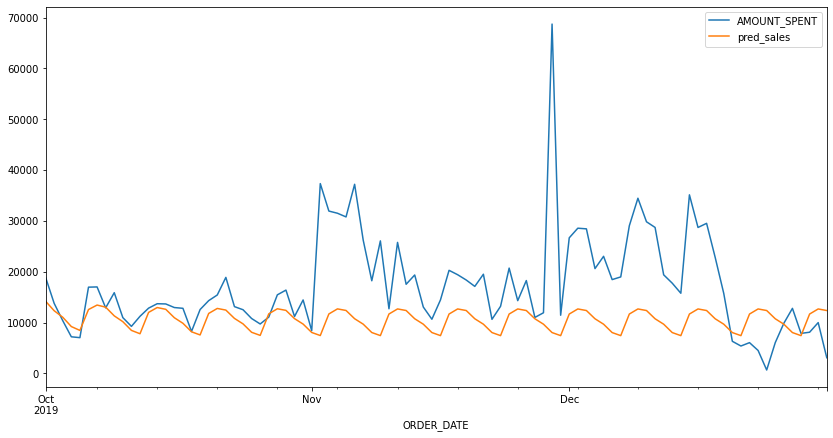

In [ ]:
arima_test_df['pred_sales'] = results.predict(start=456,end=549, dynamic= True)
arima_test_df[['AMOUNT_SPENT','pred_sales']].plot(figsize=(14,7))


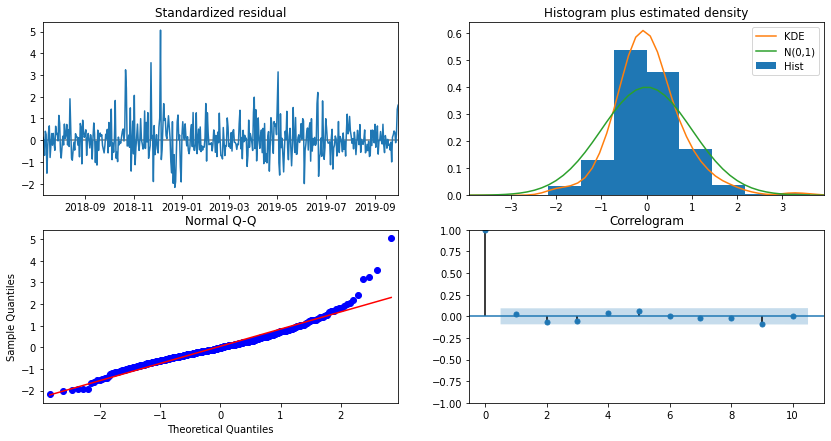

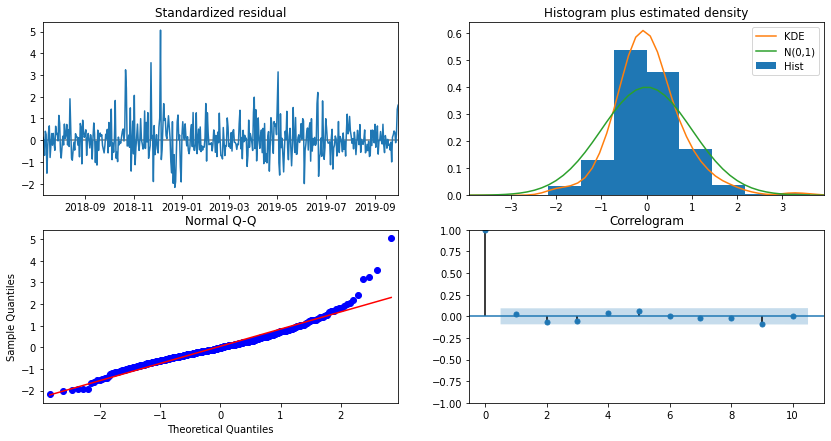

In [ ]:
# fit the model
sarima_model = SARIMAX(arima_df.AMOUNT_SPENT, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=456,end= 549, dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

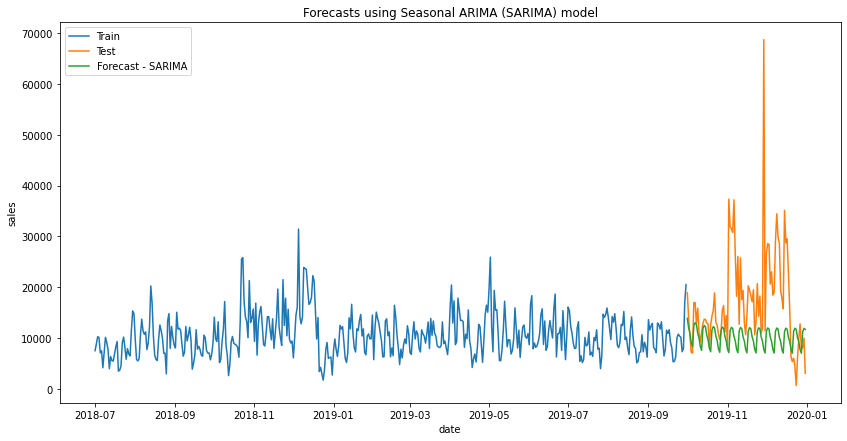

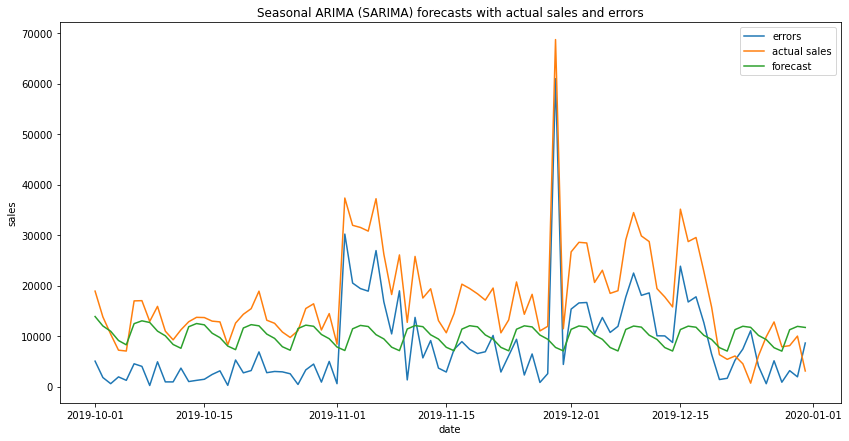

NameError: ignored

In [ ]:
# eval
arima_test_df['errors'] = arima_test_df.AMOUNT_SPENT - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['ORDER_DATE'], train_df['AMOUNT_SPENT'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['AMOUNT_SPENT'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['AMOUNT_SPENT'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()

result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('AMOUNT_SPENT', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_sarima

# Linear regression Final model for implementation

In [ ]:
reg_df = df
reg_df

,ORDER_DATE,AMOUNT_SPENT,year,month,day,weekday
0,2018-07-01,7516.37,2018,7,1,6
1,2018-07-02,8947.50,2018,7,2,7
2,2018-07-03,10268.88,2018,7,3,1
3,2018-07-04,10143.30,2018,7,4,2
4,2018-07-05,7088.92,2018,7,5,3
...,...,...,...,...,...,...
544,2019-12-27,12797.01,2019,12,27,4
545,2019-12-28,7873.96,2019,12,28,5
546,2019-12-29,8100.44,2019,12,29,6
547,2019-12-30,9992.00,2019,12,30,7


In [ ]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.AMOUNT_SPENT.shift(i)
    
# Rolling window
reg_df['rolling_mean'] = reg_df.AMOUNT_SPENT.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.AMOUNT_SPENT.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.AMOUNT_SPENT.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
#reg_df = reg_df.drop(['ORDER_STATUS', 'ORDER_TOTAL','PRODUCT_AMOUNT','ORDER_ID','PRODUCT_PRICE','PRODUCT_ID','PRODUCT_TITLE1','PRODUCT_DISCOUNT','DELIVERY_PRICE','month_year'], axis=1)

# Split the series to predict the last 3 months of 2017
reg_df = reg_df.set_index('ORDER_DATE')
reg_train_df = reg_df.loc[:'2019-12-30']                        
reg_test_df = reg_df.loc['2020-01-01':]

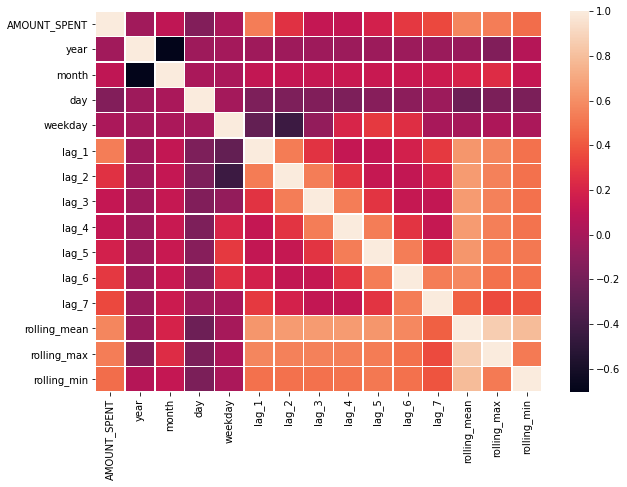

In [ ]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [ ]:
X_train = reg_train_df.drop(['AMOUNT_SPENT'], axis=1)
y_train = reg_train_df['AMOUNT_SPENT'].values

X_test = reg_test_df.drop(['AMOUNT_SPENT'], axis=1)
y_test = reg_test_df['AMOUNT_SPENT'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature       Score
11  rolling_mean  220.354656
12   rolling_max  185.142348
4          lag_1  179.928269
13   rolling_min  131.511073
10         lag_7   62.600876


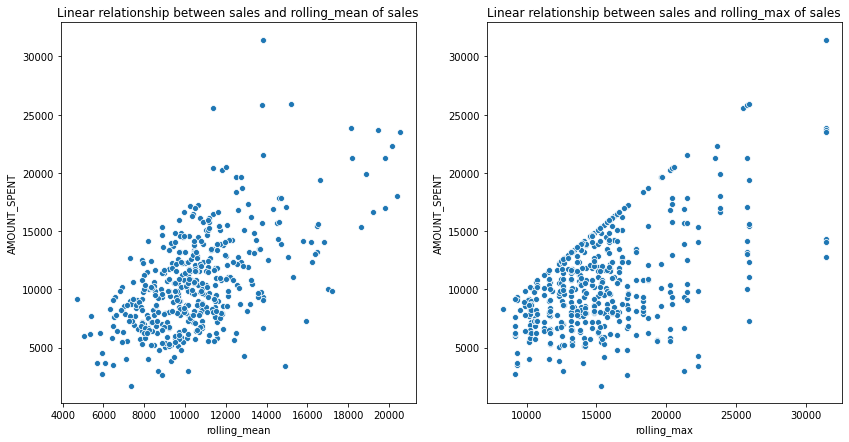

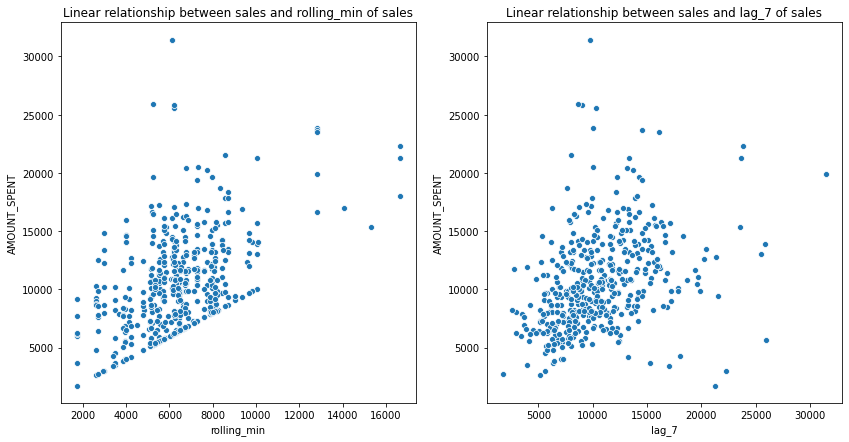

In [ ]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_mean, reg_train_df.AMOUNT_SPENT, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(reg_train_df.rolling_max, reg_train_df.AMOUNT_SPENT, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_min, reg_train_df.AMOUNT_SPENT, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(reg_train_df.lag_7, reg_train_df.AMOUNT_SPENT, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [ ]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['AMOUNT_SPENT']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

In [ ]:
errors_df

,model,AMOUNT_SPENT,pred_sales,errors
ORDER_DATE,,,,
2019-10-01,LinearRegression,18898.27,14987.016153,-3911.253847
2019-10-02,LinearRegression,13784.86,14486.673388,701.813388
2019-10-03,LinearRegression,10376.69,13035.074347,2658.384347
2019-10-04,LinearRegression,7201.74,11730.384243,4528.644243
2019-10-05,LinearRegression,7033.30,10860.984817,3827.684817
...,...,...,...,...
2019-12-27,LinearRegression,12797.01,7461.813498,-5335.196502
2019-12-28,LinearRegression,7873.96,8168.279118,294.319118
2019-12-29,LinearRegression,8100.44,6869.752143,-1230.687857


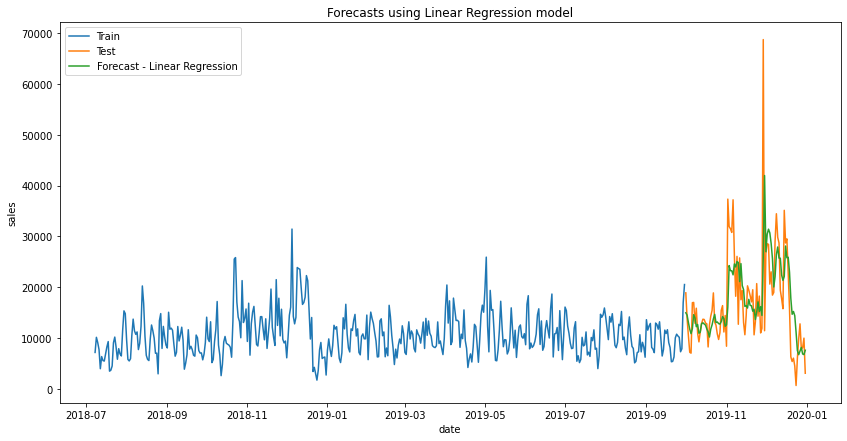

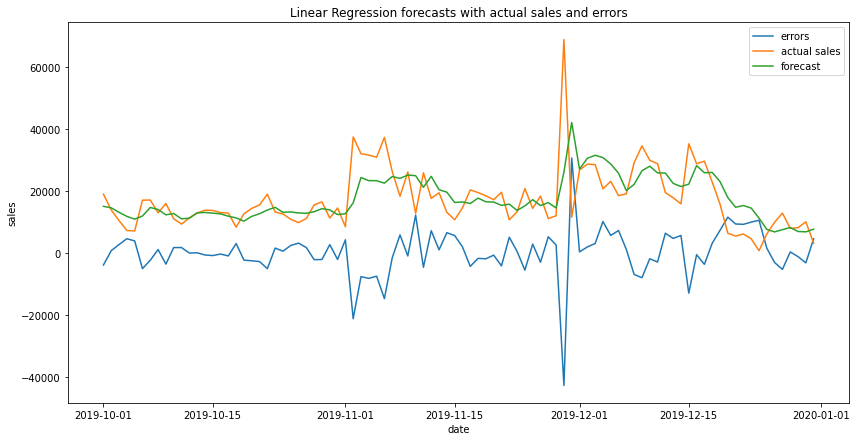

,total_sales,total_pred_sales,LR_overall_error
model,,,
LinearRegression,1590103.1,1.605439e+06,15336.014513


In [ ]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['AMOUNT_SPENT'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['AMOUNT_SPENT'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.AMOUNT_SPENT, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('AMOUNT_SPENT', 'sum'),total_pred_sales=('pred_sales', 'sum'),LR_overall_error=('errors', 'sum'))
result_df_lr

In [ ]:
from sklearn import metrics

In [ ]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, preds), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, preds), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, preds), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, preds), 2)) 
print("R2 score =", round(sm.r2_score(y_test, preds), 2))

Mean absolute error = 4924.92
Mean squared error = 60551984.0
Median absolute error = 3095.04
Explain variance score = 0.36
R2 score = 0.36
